In [1]:
# pip install kagglehub
# !pip install imblearn
# !pip install shap

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("raghadalharbi/breast-cancer-gene-expression-profiles-metabric")

# print("Path to dataset files:", path)

In [3]:
# import shutil
# import os

# # Path to the already downloaded dataset
# source_directory = path

# # Destination directory (current working directory './')
# destination_directory = './'

# # Check if the destination directory exists, if not, create it
# if not os.path.exists(destination_directory):
#     os.makedirs(destination_directory)

# # Move the dataset to the specified directory
# for filename in os.listdir(source_directory):
#     source_path = os.path.join(source_directory, filename)
#     destination_path = os.path.join(destination_directory, filename)
#     shutil.move(source_path, destination_path)

# print(f"Dataset moved to: {os.path.abspath(destination_directory)}")

In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('METABRIC_RNA_Mutation.csv')

# View basic info to understand the data structure
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB
None
   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   

/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
## Chceck for the missing values
def check_missing_values(data):
    # Display missing values for each column with missing entries
    missing_values = data.isnull().sum()
    missing_columns = missing_values[missing_values > 0]
    print("Columns with missing values:\n", missing_columns)

    # Display data types of all columns to check for necessary conversions
    data_types = data.dtypes
    print("\nData types for each column:\n", data_types)

In [6]:
check_missing_values(df)

Columns with missing values:
 type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
death_from_cancer                   1
dtype: int64

Data types for each column:
 patient_id                  int64
age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type                object
cancer_type_detailed       object
                           ...   
hras_mut                   object
prps2_mut                  object
smarcb1_mut                object
stmn2_mut                  object
siah1_mut                  object
Length: 693, dtype: object


In [7]:
# Impute remaining categorical columns with mode
df['cellularity'].fillna(df['cellularity'].mode()[0], inplace=True)
df['tumor_other_histologic_subtype'].fillna(df['tumor_other_histologic_subtype'].mode()[0], inplace=True)
df['oncotree_code'].fillna(df['oncotree_code'].mode()[0], inplace=True)

# Impute `neoplasm_histologic_grade` with median as it’s an ordinal numeric column
df['neoplasm_histologic_grade'].fillna(df['neoplasm_histologic_grade'].median(), inplace=True)

In [8]:
# Drop columns with high missing rates
df = df.drop(columns=['tumor_stage'])

# Impute categorical columns with mode
categorical_cols = ['type_of_breast_surgery', 'cancer_type_detailed', 'er_status_measured_by_ihc', 'primary_tumor_laterality']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Impute numerical columns with median
numerical_cols = ['age_at_diagnosis', 'tumor_size', 'mutation_count']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Drop rows with missing values in 'death_from_cancer'
df = df.dropna(subset=['death_from_cancer'])

# Handle `3-gene_classifier_subtype` by dropping or creating an indicator column
# Option 1: Drop the column if it’s not crucial
# df = df.drop(columns=['3-gene_classifier_subtype'])

# Option 2: Create an indicator column for missing data
df['3-gene_classifier_subtype_missing'] = df['3-gene_classifier_subtype'].isnull().astype(int)
df['3-gene_classifier_subtype'].fillna(df['3-gene_classifier_subtype'].mode()[0], inplace=True)

# Convert mutation columns and other categorical columns to integer/category as needed
mutation_cols = [col for col in df.columns if '_mut' in col]
df[mutation_cols] = df[mutation_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Convert key categorical features to category type
df[categorical_cols + ['cancer_type', 'er_status', 'her2_status']] = df[categorical_cols + ['cancer_type', 'er_status', 'her2_status']].astype('category')

In [9]:
##recheck for the missing values
check_missing_values(df)

Columns with missing values:
 Series([], dtype: int64)

Data types for each column:
 patient_id                              int64
age_at_diagnosis                      float64
type_of_breast_surgery               category
cancer_type                          category
cancer_type_detailed                 category
                                       ...   
prps2_mut                               int64
smarcb1_mut                             int64
stmn2_mut                               int64
siah1_mut                               int64
3-gene_classifier_subtype_missing       int64
Length: 693, dtype: object


## Step2: Encoding and Scaling
## Encoding: One-Hot Encoding
## Scaling: Standard Scaling

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def check_missing_values_and_types(df):
    """Prints missing values and data types for each column."""
    missing_values = df.isnull().sum()
    print("Missing Values:\n", missing_values[missing_values > 0])
    print("\nData Types:\n", df.dtypes)

def encode_categorical(df, categorical_cols):
    """Applies one-hot encoding to specified categorical columns and returns the modified DataFrame."""
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print("\nAfter Encoding:\n", df_encoded.head())
    print("\nShape after encoding:", df_encoded.shape)
    return df_encoded

def scale_numerical(df, numerical_cols):
    """Scales numerical columns and returns the DataFrame with scaled columns."""
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    print("\nAfter Scaling:\n", df[numerical_cols].head())
    return df

def compare_before_after(original_df, modified_df):
    """Compares the original and modified DataFrames, showing differences in shape and column names."""
    print("\nOriginal Shape:", original_df.shape)
    print("Modified Shape:", modified_df.shape)
    original_cols = set(original_df.columns)
    modified_cols = set(modified_df.columns)
    added_cols = modified_cols - original_cols
    print("\nColumns added after encoding:\n", added_cols)
    
# Define columns to encode and scale
categorical_cols = ['type_of_breast_surgery', 'cancer_type', 'primary_tumor_laterality', 'cellularity', 
                    'tumor_other_histologic_subtype', 'oncotree_code', '3-gene_classifier_subtype']
numerical_cols = ['age_at_diagnosis', 'tumor_size', 'mutation_count', 'nottingham_prognostic_index']

# Original data overview
print("Original Data Overview:")
check_missing_values_and_types(df)

# Encoding and scaling steps
df_encoded = encode_categorical(df, categorical_cols)
df_encoded_scaled = scale_numerical(df_encoded, numerical_cols)

# Compare before and after transformations
compare_before_after(df, df_encoded_scaled)

Original Data Overview:
Missing Values:
 Series([], dtype: int64)

Data Types:
 patient_id                              int64
age_at_diagnosis                      float64
type_of_breast_surgery               category
cancer_type                          category
cancer_type_detailed                 category
                                       ...   
prps2_mut                               int64
smarcb1_mut                             int64
stmn2_mut                               int64
siah1_mut                               int64
3-gene_classifier_subtype_missing       int64
Length: 693, dtype: object

After Encoding:
    patient_id  age_at_diagnosis                       cancer_type_detailed  \
0           0             75.65           Breast Invasive Ductal Carcinoma   
1           2             43.19           Breast Invasive Ductal Carcinoma   
2           5             48.87           Breast Invasive Ductal Carcinoma   
3           6             47.68  Breast Mixed Ductal and 

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_pca(data, n_components=20):
    """
    Perform PCA on the data and plot cumulative explained variance.
    Args:
        data (DataFrame): Input data after encoding and scaling.
        n_components (int): Number of principal components to compute.
    Returns:
        pca_result (DataFrame): Transformed data with principal components.
        explained_variance (array): Explained variance ratio of components.
    """
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    # Calculate cumulative explained variance
    explained_variance = pca.explained_variance_ratio_.cumsum()

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), explained_variance, marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA - Cumulative Explained Variance")
    plt.grid(True)
    plt.show()

    return pca_result, explained_variance



In [12]:
def check_and_convert_all_categorical(df):
    """Converts all categorical columns to dummy variables to ensure numeric-only DataFrame."""
    # Identify non-numeric columns
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        print("Non-numeric columns found. Converting to dummy variables for:", non_numeric_cols)
        # Apply one-hot encoding to all non-numeric columns at once
        df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)
    else:
        print("All columns are numeric.")
    return df

# Ensure all columns are numeric by encoding remaining non-numeric columns
df_numeric = check_and_convert_all_categorical(df_encoded_scaled)


Non-numeric columns found. Converting to dummy variables for: Index(['pam50_+_claudin-low_subtype', 'her2_status_measured_by_snp6',
       'inferred_menopausal_state', 'integrative_cluster', 'pr_status',
       'death_from_cancer'],
      dtype='object')


In [13]:
# Step 1: Identify and display any non-numeric columns still present
non_numeric_cols = df_encoded_scaled.select_dtypes(include=['object']).columns
print("Non-numeric columns remaining:", non_numeric_cols)

# Step 2: Convert these remaining columns explicitly to numeric using one-hot encoding
df_fully_encoded = pd.get_dummies(df_encoded_scaled, columns=non_numeric_cols, drop_first=True)

# Step 3: Verify all columns are now numeric
assert df_fully_encoded.select_dtypes(include=['object']).empty, "Non-numeric columns still exist!"

# Step 4: Run PCA on the fully numeric dataset
# pca_result, explained_variance = perform_pca(df_fully_encoded, n_components=20)
non_numeric_cols = df_fully_encoded.select_dtypes(include=['object']).columns
print("Non-numeric columns remaining:", non_numeric_cols)

Non-numeric columns remaining: Index(['pam50_+_claudin-low_subtype', 'her2_status_measured_by_snp6',
       'inferred_menopausal_state', 'integrative_cluster', 'pr_status',
       'death_from_cancer'],
      dtype='object')
Non-numeric columns remaining: Index([], dtype='object')


In [14]:
# Step 1: Force conversion to numeric to identify any problematic entries
def check_for_non_numeric(df):
    """Converts all values to numeric and identifies problematic entries."""
    non_numeric = pd.DataFrame()
    for col in df.columns:
        # Try converting each column to numeric, and record any issues
        try:
            pd.to_numeric(df[col], errors='raise')
        except ValueError:
            non_numeric = non_numeric.append(df[[col]], ignore_index=False)
            print(f"Non-numeric data found in column '{col}'")

# Apply this function to identify remaining issues
check_for_non_numeric(df_fully_encoded)

Non-numeric data found in column 'cancer_type_detailed'
Non-numeric data found in column 'er_status_measured_by_ihc'
Non-numeric data found in column 'er_status'
Non-numeric data found in column 'her2_status'


In [15]:
# Apply one-hot encoding specifically to the remaining non-numeric columns
columns_to_encode = ['cancer_type_detailed', 'er_status_measured_by_ihc', 'er_status', 'her2_status']
df_fully_encoded = pd.get_dummies(df_fully_encoded, columns=columns_to_encode, drop_first=True)

# Verify that all columns are now numeric
check_for_non_numeric(df_fully_encoded)

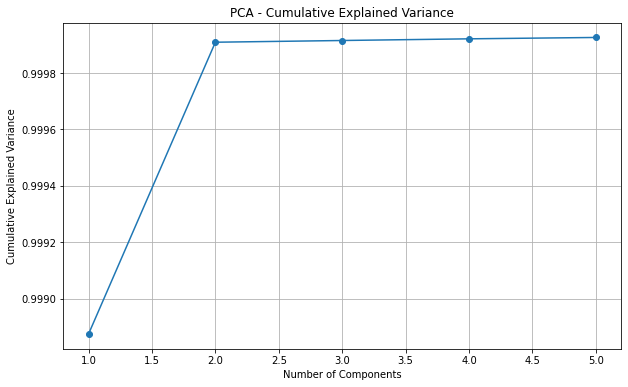

In [16]:
pca_result, explained_variance = perform_pca(df_fully_encoded, n_components=5)

In [17]:
# Define features (X) and target (y)
X = df_fully_encoded
# Convert to a list and print all columns
columns_list = X.columns.tolist()
print("Columns in X:\n", columns_list)

Columns in X:
 ['patient_id', 'age_at_diagnosis', 'chemotherapy', 'cohort', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'overall_survival', 'radio_therapy', 'tumor_size', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e2f3', 'e2f4', 'e2f5', 'e2f6', 'e2f7', 'e2f8', 'src', 'jak1', 'jak2', 'stat1', 'stat2', 'stat3', 'stat5a', 'stat5b', 'mdm2', 'tp53bp1', 'adam10', 'adam17', 'aph1a', 'aph1b', 'arrdc1', 'cir1', 'ctbp1', 'ctbp2', 'cul1', 'dll1', 'dll3', 'dll4', 'dtx1', 'dtx2', 'dtx3', 'dtx4', 'ep300', 'fbxw7', 'hdac1', 'hdac2', 'hes1', 'hes5', 'heyl', 'itch', 'jag1', 'jag2', 'kdm5a', 'lfng'


Logistic Regression Cross-Validation Scores: [0.84552846 0.87804878 0.83739837 0.85365854 0.84552846]
Logistic Regression Mean Cross-Validation Score: 0.8520325203252032

Logistic Regression Accuracy on Test Set: 0.8571428571428571
Logistic Regression ROC-AUC Score: 0.9392930327868853

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.88      0.72        32
           1       0.96      0.85      0.90       122

    accuracy                           0.86       154
   macro avg       0.79      0.86      0.81       154
weighted avg       0.89      0.86      0.87       154

Logistic Regression Confusion Matrix:
 [[ 28   4]
 [ 18 104]]

Out of 154 test samples:
 - Predicted Survived: 108 (70.13%)
 - Predicted Not Survived: 46 (29.87%)
 - Actual Survived: 122 (79.22%)
 - Actual Not Survived: 32 (20.78%)

Logistic Regression Top 10 Important Features:
age_at_diagnosis: 2.1590
type_of_breast_surgery_MASTECTOMY: 1

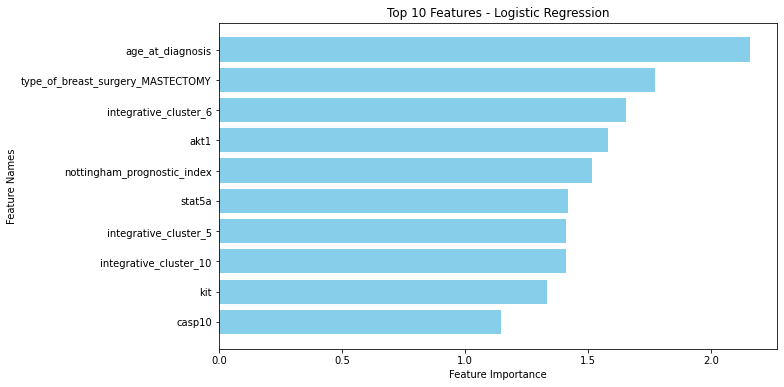

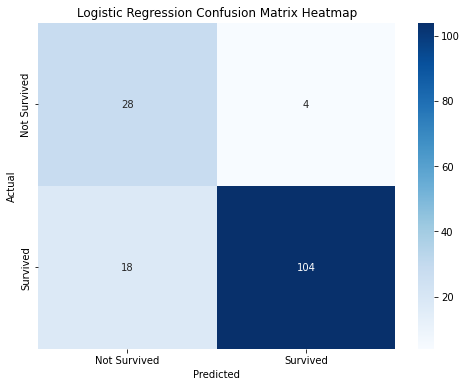

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


y = df['overall_survival']  # Predicting survival

# Step 2: Drop Leakage Features
leakage_columns = ['overall_survival_months', 'overall_survival', 
                   'death_from_cancer_Died of Other Causes', 'death_from_cancer_Living']
X_cleaned = X.drop(columns=leakage_columns, errors='ignore')  # Remove leakage columns explicitly


# Step 1: Preprocessing
X_cleaned = X.drop(columns=leakage_columns, errors='ignore')  # Remove leakage features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_cleaned)

# Step 2: Feature Selection
k = 300  # Number of features to keep
selector = SelectKBest(chi2, k=k)
X_reduced = selector.fit_transform(X_scaled, y)

# Get feature names after SelectKBest
selected_feature_names = X_cleaned.columns[selector.get_support()]

# Step 3: Address Class Imbalance
smote = SMOTEENN(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_reduced, y)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Function to evaluate and print results
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\n{model_name} Cross-Validation Scores:", cv_scores)
    print(f"{model_name} Mean Cross-Validation Score:", cv_scores.mean())

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    print(f"\n{model_name} Accuracy on Test Set:", accuracy)
    if roc_auc:
        print(f"{model_name} ROC-AUC Score:", roc_auc)

    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:\n", conf_matrix)

    # Percentages
    total_samples = len(y_test)
    predicted_survived = sum(y_pred == 1)
    predicted_not_survived = sum(y_pred == 0)
    actual_survived = sum(y_test == 1)
    actual_not_survived = sum(y_test == 0)

    print(f"\nOut of {total_samples} test samples:")
    print(f" - Predicted Survived: {predicted_survived} ({predicted_survived / total_samples * 100:.2f}%)")
    print(f" - Predicted Not Survived: {predicted_not_survived} ({predicted_not_survived / total_samples * 100:.2f}%)")
    print(f" - Actual Survived: {actual_survived} ({actual_survived / total_samples * 100:.2f}%)")
    print(f" - Actual Not Survived: {actual_not_survived} ({actual_not_survived / total_samples * 100:.2f}%)")

    # Feature Importance
    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        if hasattr(model, "coef_"):
            feature_importance = np.abs(model.coef_[0])
        else:
            feature_importance = model.feature_importances_
        important_features = sorted(zip(selected_feature_names, feature_importance), key=lambda x: x[1], reverse=True)

        print(f"\n{model_name} Top 10 Important Features:")
        for feature, importance in important_features[:10]:
            print(f"{feature}: {importance:.4f}")

        # Visualization: Feature Importance Bar Chart
        top_features = important_features[:10]
        features, importances = zip(*top_features)

        plt.figure(figsize=(10, 6))
        plt.barh(features, importances, color='skyblue')
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature Names")
        plt.title(f"Top 10 Features - {model_name}")
        plt.gca().invert_yaxis()
        plt.show()

    # Visualization: Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
    plt.title(f"{model_name} Confusion Matrix Heatmap")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Logistic Regression
log_reg_model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, solver='saga')
evaluate_model(log_reg_model, "Logistic Regression", X_train, y_train, X_test, y_test)



Random Forest Cross-Validation Scores: [0.84552846 0.8699187  0.83739837 0.82113821 0.80487805]
Random Forest Mean Cross-Validation Score: 0.8357723577235772

Random Forest Accuracy on Test Set: 0.8636363636363636
Random Forest ROC-AUC Score: 0.9164959016393442

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.38      0.53        32
           1       0.86      0.99      0.92       122

    accuracy                           0.86       154
   macro avg       0.89      0.68      0.73       154
weighted avg       0.87      0.86      0.84       154

Random Forest Confusion Matrix:
 [[ 12  20]
 [  1 121]]

Out of 154 test samples:
 - Predicted Survived: 141 (91.56%)
 - Predicted Not Survived: 13 (8.44%)
 - Actual Survived: 122 (79.22%)
 - Actual Not Survived: 32 (20.78%)

Random Forest Top 10 Important Features:
type_of_breast_surgery_MASTECTOMY: 0.0384
age_at_diagnosis: 0.0316
kit: 0.0204
flt3: 0.0184
tumor_size: 

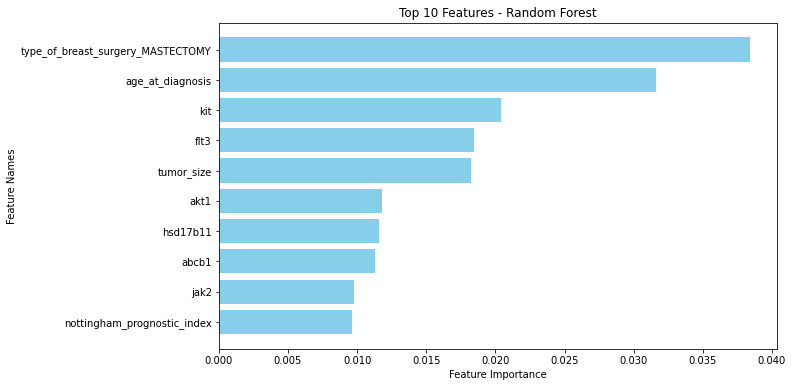

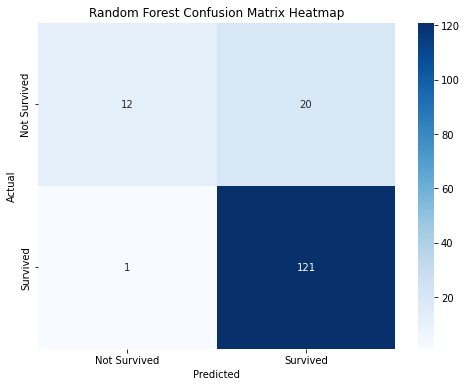

In [35]:

# Random Forest
rf_model = RandomForestClassifier(n_estimators=300, max_depth=18, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=42)
evaluate_model(rf_model, "Random Forest", X_train, y_train, X_test, y_test)



Gradient Boosting Cross-Validation Scores: [0.85365854 0.86178862 0.88617886 0.8699187  0.84552846]
Gradient Boosting Mean Cross-Validation Score: 0.8634146341463416

Gradient Boosting Accuracy on Test Set: 0.9155844155844156
Gradient Boosting ROC-AUC Score: 0.9469774590163934

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75        32
           1       0.91      0.99      0.95       122

    accuracy                           0.92       154
   macro avg       0.93      0.81      0.85       154
weighted avg       0.92      0.92      0.91       154

Gradient Boosting Confusion Matrix:
 [[ 20  12]
 [  1 121]]

Out of 154 test samples:
 - Predicted Survived: 133 (86.36%)
 - Predicted Not Survived: 21 (13.64%)
 - Actual Survived: 122 (79.22%)
 - Actual Not Survived: 32 (20.78%)

Gradient Boosting Top 10 Important Features:
type_of_breast_surgery_MASTECTOMY: 0.1192
age_at_diagnosis: 0.0936
akt1: 0.

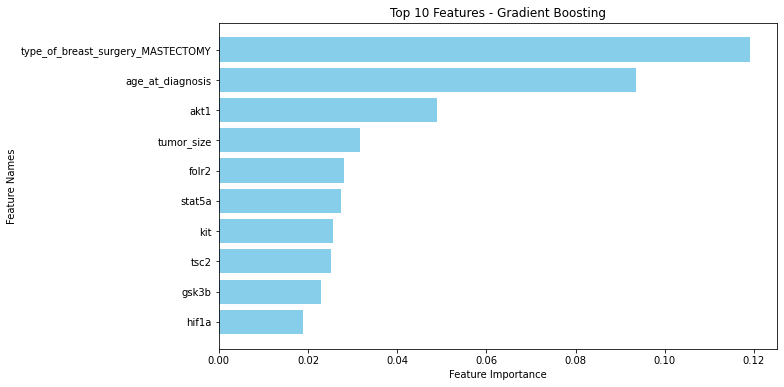

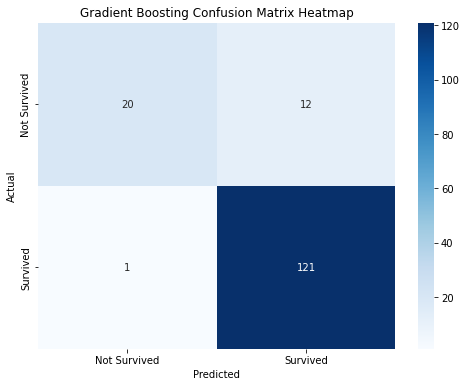

In [36]:

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
evaluate_model(gb_model, "Gradient Boosting", X_train, y_train, X_test, y_test)


In [22]:
# Import Libraries
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Define Target Variable (Subtype Prediction)
y = df['pam50_+_claudin-low_subtype']  # Replace with the column name for subtype

# Drop Leakage Features
leakage_columns_subtype = [
    '3-gene_classifier_subtype_ER-/HER2-', 
    '3-gene_classifier_subtype_HER2+',
    '3-gene_classifier_subtype_ER+/HER2- Low Prolif',
    'pam50_+_claudin-low_subtype_Her2',
    'pam50_+_claudin-low_subtype_LumA',
    'pam50_+_claudin-low_subtype_LumB',
    'pam50_+_claudin-low_subtype_NC',
    'pam50_+_claudin-low_subtype_Normal',
    'pam50_+_claudin-low_subtype_claudin-low',
    'er_status_measured_by_ihc_Positve',
    'er_status_Positive',
    'pr_status_Positive',
    'cancer_type_detailed_Breast Invasive Ductal Carcinoma',
    'cancer_type_detailed_Breast Invasive Lobular Carcinoma',
    'cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma',
    'cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma',
    'cancer_type_detailed_Metaplastic Breast Cancer',
    'her2_status_Positive',
    'tumor_other_histologic_subtype_Lobular',
    'tumor_other_histologic_subtype_Medullary',
    'tumor_other_histologic_subtype_Metaplastic',
    'tumor_other_histologic_subtype_Mixed',
    'tumor_other_histologic_subtype_Mucinous',
    'tumor_other_histologic_subtype_Other',
    'tumor_other_histologic_subtype_Tubular/ cribriform'
]


X_cleaned = X.drop(columns=leakage_columns_subtype, errors='ignore')  # Remove leakage columns explicitly


In [23]:
X_cleaned.columns.tolist()

['patient_id',
 'age_at_diagnosis',
 'chemotherapy',
 'cohort',
 'neoplasm_histologic_grade',
 'hormone_therapy',
 'lymph_nodes_examined_positive',
 'mutation_count',
 'nottingham_prognostic_index',
 'overall_survival_months',
 'overall_survival',
 'radio_therapy',
 'tumor_size',
 'brca1',
 'brca2',
 'palb2',
 'pten',
 'tp53',
 'atm',
 'cdh1',
 'chek2',
 'nbn',
 'nf1',
 'stk11',
 'bard1',
 'mlh1',
 'msh2',
 'msh6',
 'pms2',
 'epcam',
 'rad51c',
 'rad51d',
 'rad50',
 'rb1',
 'rbl1',
 'rbl2',
 'ccna1',
 'ccnb1',
 'cdk1',
 'ccne1',
 'cdk2',
 'cdc25a',
 'ccnd1',
 'cdk4',
 'cdk6',
 'ccnd2',
 'cdkn2a',
 'cdkn2b',
 'myc',
 'cdkn1a',
 'cdkn1b',
 'e2f1',
 'e2f2',
 'e2f3',
 'e2f4',
 'e2f5',
 'e2f6',
 'e2f7',
 'e2f8',
 'src',
 'jak1',
 'jak2',
 'stat1',
 'stat2',
 'stat3',
 'stat5a',
 'stat5b',
 'mdm2',
 'tp53bp1',
 'adam10',
 'adam17',
 'aph1a',
 'aph1b',
 'arrdc1',
 'cir1',
 'ctbp1',
 'ctbp2',
 'cul1',
 'dll1',
 'dll3',
 'dll4',
 'dtx1',
 'dtx2',
 'dtx3',
 'dtx4',
 'ep300',
 'fbxw7',
 'hdac1',


Fitting 3 folds for each of 81 candidates, totalling 243 fits

Accuracy: 0.9730458221024259

Classification Report:
               precision    recall  f1-score   support

       Basal       0.98      0.96      0.97       127
        Her2       0.95      1.00      0.97       124
        LumA       1.00      0.57      0.72        23
        LumB       0.92      0.97      0.95        75
          NC       1.00      1.00      1.00       136
      Normal       0.96      0.99      0.98       130
 claudin-low       1.00      0.98      0.99       127

    accuracy                           0.97       742
   macro avg       0.97      0.93      0.94       742
weighted avg       0.97      0.97      0.97       742


Confusion Matrix:
 [[122   4   0   0   0   1   0]
 [  0 124   0   0   0   0   0]
 [  0   0  13   6   0   4   0]
 [  0   2   0  73   0   0   0]
 [  0   0   0   0 136   0   0]
 [  0   1   0   0   0 129   0]
 [  2   0   0   0   0   0 125]]
 - Predicted claudin-low: 125 (16.85%)
 - Actual

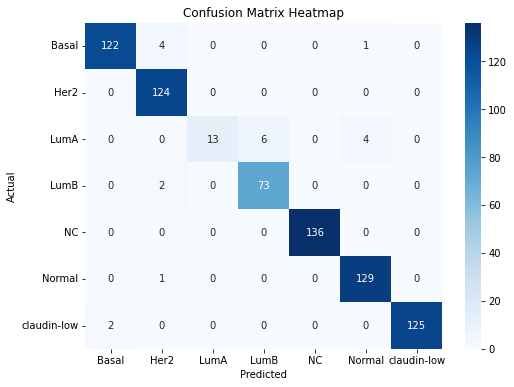

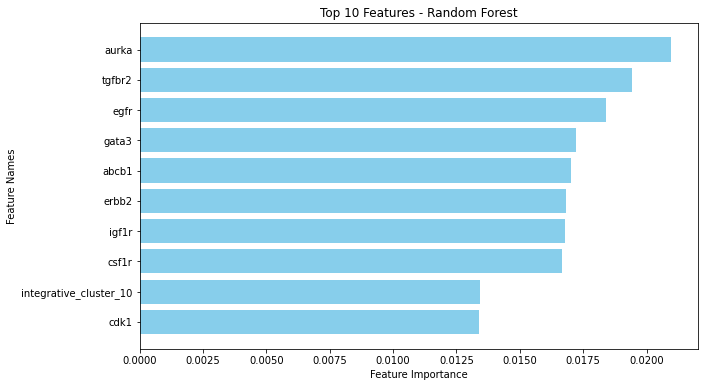

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import MinMaxScaler

# Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_cleaned)

# Feature Selection
k = 300  # Experiment with larger k if needed
selector = SelectKBest(chi2, k=k)
X_reduced = selector.fit_transform(X_scaled, y)
selected_feature_names = X_cleaned.columns[selector.get_support()]

# Address Class Imbalance
smoteenn = SMOTEENN(random_state=42)
X_balanced, y_balanced = smoteenn.fit_resample(X_reduced, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Train with Best Parameters
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Percentages
total_samples = len(y_test)
for label in set(y):
    predicted_count = sum(y_pred == label)
    actual_count = sum(y_test == label)
    print(f" - Predicted {label}: {predicted_count} ({predicted_count / total_samples * 100:.2f}%)")
    print(f" - Actual {label}: {actual_count} ({actual_count / total_samples * 100:.2f}%)")

# Feature Importance
feature_importance = best_rf_model.feature_importances_
important_features = sorted(zip(selected_feature_names, feature_importance), key=lambda x: x[1], reverse=True)
print("\nTop 10 Important Features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance:.4f}")

# Visualization: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization: Feature Importance Bar Chart
top_features = important_features[:10]
features, importances = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 10 Features - Random Forest")
plt.gca().invert_yaxis()
plt.show()

# ROC Curve (for binary classification only)
if len(set(y)) == 2:
    y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("\nROC-AUC Score:", roc_auc)

    RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test)
    plt.title("ROC Curve")
    plt.show()


[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.9s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.9s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   4.0s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] 

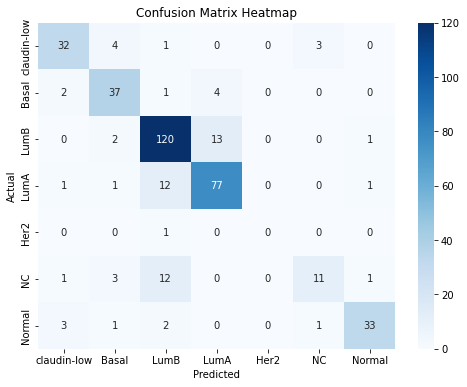

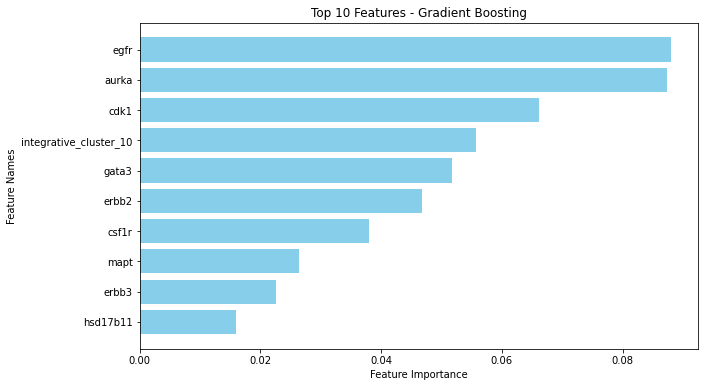

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_cleaned)

# Feature Selection
k = 300  # Experiment with larger k if needed
selector = SelectKBest(chi2, k=k)
X_reduced = selector.fit_transform(X_scaled, y)
selected_feature_names = X_cleaned.columns[selector.get_support()]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Cross-Validation
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

# Predictions
y_pred = gb_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Percentages
total_samples = len(y_test)
for label in set(y):
    predicted_count = sum(y_pred == label)
    actual_count = sum(y_test == label)
    print(f" - Predicted {label}: {predicted_count} ({predicted_count / total_samples * 100:.2f}%)")
    print(f" - Actual {label}: {actual_count} ({actual_count / total_samples * 100:.2f}%)")

# Feature Importance
feature_importance = gb_model.feature_importances_
important_features = sorted(zip(selected_feature_names, feature_importance), key=lambda x: x[1], reverse=True)
print("\nTop 10 Important Features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance:.4f}")

# Visualization: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y), yticklabels=set(y))
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization: Feature Importance Bar Chart
top_features = important_features[:10]
features, importances = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 10 Features - Gradient Boosting")
plt.gca().invert_yaxis()
plt.show()

# ROC-AUC Score (if applicable)
if len(set(y)) == 2:  # For binary classification
    y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("\nROC-AUC Score:", roc_auc)

    # Plot ROC Curve
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_estimator(gb_model, X_test, y_test)
    plt.title("ROC Curve")
    plt.show()


In [27]:
# Define treatment_response dynamically if it doesn't exist
if 'treatment_response' not in df.columns:
    print("Creating 'treatment_response' column...")
    # Example: Positive treatment response based on certain conditions
    df['treatment_response'] = (
        (df['chemotherapy'] == 1) |
        (df['hormone_therapy'] == 1) |
        (df['radio_therapy'] == 1)
    ).astype(int)
    print("'treatment_response' column created.")
else:
    print("'treatment_response' already exists.")

# Set target variable
y = df['treatment_response']


Creating 'treatment_response' column...
'treatment_response' column created.



Accuracy: 0.8503937007874016

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.33      0.40        58
           1       0.89      0.94      0.91       323

    accuracy                           0.85       381
   macro avg       0.70      0.64      0.66       381
weighted avg       0.83      0.85      0.84       381


Confusion Matrix:
 [[ 19  39]
 [ 18 305]]
 - Predicted 0: 37 (9.71%)
 - Actual 0: 58 (15.22%)
 - Predicted 1: 344 (90.29%)
 - Actual 1: 323 (84.78%)

Top 10 Important Features:
num__lymph_nodes_examined_positive: 0.1567
cat__type_of_breast_surgery_BREAST CONSERVING: 0.1331
cat__type_of_breast_surgery_MASTECTOMY: 0.1234
num__patient_id: 0.0572
num__nottingham_prognostic_index: 0.0502
num__maml1: 0.0173
num__cdkn1a: 0.0172
num__cohort: 0.0163
num__map3k5: 0.0126
num__jag1: 0.0119


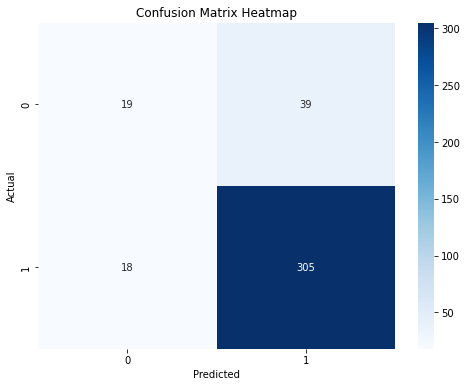

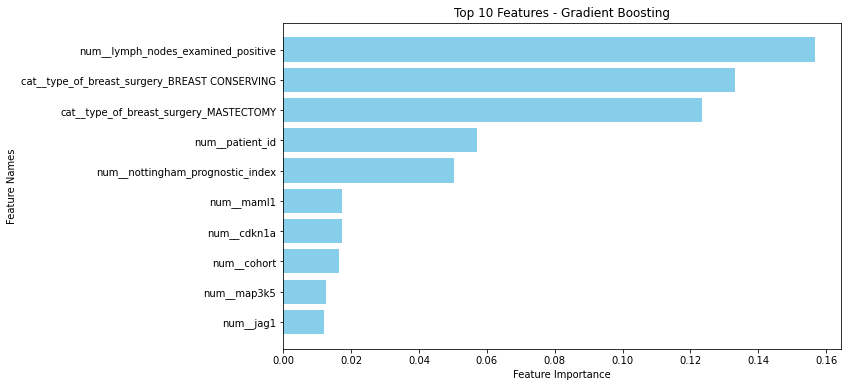

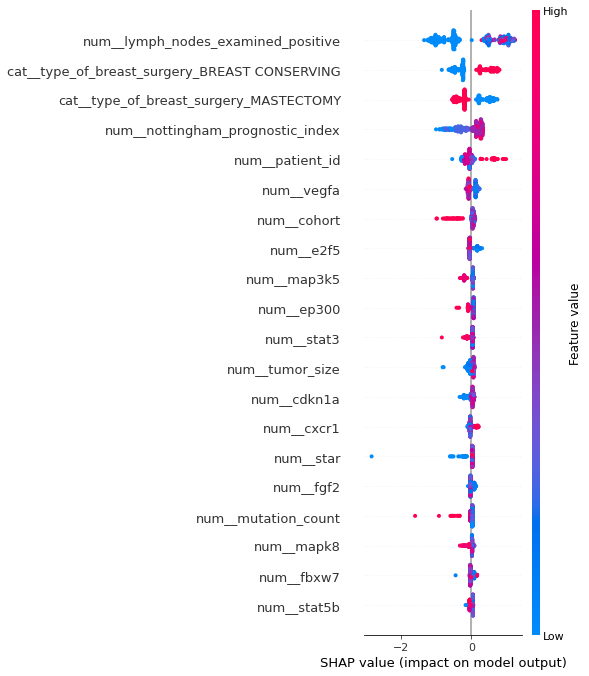

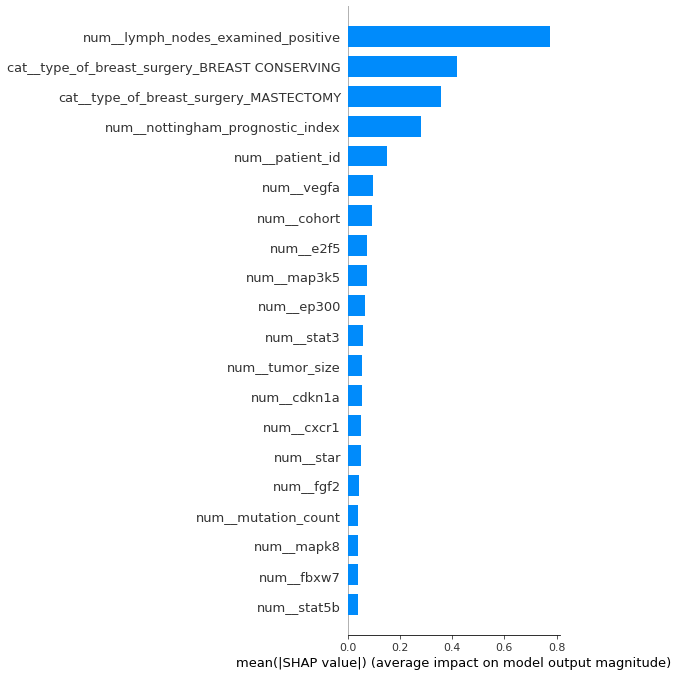

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Step 1: Drop Leakage Columns
leakage_columns = [
    'overall_survival', 
    'overall_survival_months', 
    'death_from_cancer_Died of Disease', 
    'death_from_cancer_Living',
    'treatment_response',  # Target variable
    'radio_therapy',       # Treatment-related features
    'hormone_therapy',
    'chemotherapy'
]

X_cleaned = df.drop(columns=leakage_columns, errors='ignore')
y = df['treatment_response']  # Target variable

# Step 2: Identify Categorical and Numerical Columns
categorical_columns = X_cleaned.select_dtypes(include=['object', 'category']).columns
numerical_columns = X_cleaned.select_dtypes(include=['number']).columns

# Step 3: Preprocess Categorical Columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
column_transformer = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', encoder, categorical_columns)
    ]
)

X_encoded = column_transformer.fit_transform(X_cleaned)

# Step 4: Scale Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Step 5: Feature Selection
k = 300  # Select top features
selector = SelectKBest(chi2, k=k)
X_reduced = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_feature_names = column_transformer.get_feature_names_out()
selected_feature_names = selected_feature_names[selector.get_support()]

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Step 7: Train Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

# Step 8: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

# Percentages
total_samples = len(y_test)
for label in set(y):
    predicted_count = sum(y_pred == label)
    actual_count = sum(y_test == label)
    print(f" - Predicted {label}: {predicted_count} ({predicted_count / total_samples * 100:.2f}%)")
    print(f" - Actual {label}: {actual_count} ({actual_count / total_samples * 100:.2f}%)")

# Feature Importance
feature_importance = gb_model.feature_importances_
important_features = sorted(
    zip(selected_feature_names, feature_importance), key=lambda x: x[1], reverse=True
)

print("\nTop 10 Important Features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance:.4f}")

# Visualization: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization: Feature Importance Bar Chart
top_features = important_features[:10]
features, importances = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 10 Features - Gradient Boosting")
plt.gca().invert_yaxis()
plt.show()

# Step 9: SHAP Analysis
explainer = shap.Explainer(gb_model, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=selected_feature_names)

# SHAP Bar Chart for Top Features
shap.summary_plot(shap_values, X_test, feature_names=selected_feature_names, plot_type="bar")


Fitting 3 folds for each of 24 candidates, totalling 72 fits

Tuned Gradient Boosting Accuracy: 0.8530183727034121

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.31      0.39        58
           1       0.88      0.95      0.92       323

    accuracy                           0.85       381
   macro avg       0.71      0.63      0.65       381
weighted avg       0.83      0.85      0.84       381


Confusion Matrix:
 [[ 18  40]
 [ 16 307]]

Top 10 Important Features (Gradient Boosting):
num__lymph_nodes_examined_positive: 0.1407
cat__type_of_breast_surgery_BREAST CONSERVING: 0.1183
cat__type_of_breast_surgery_MASTECTOMY: 0.1090
num__patient_id: 0.0518
num__nottingham_prognostic_index: 0.0465
num__cdkn1a: 0.0157
num__maml1: 0.0156
num__cohort: 0.0148
num__map3k5: 0.0117
num__jag1: 0.0113


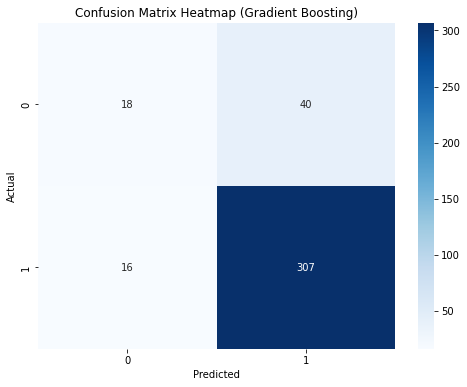

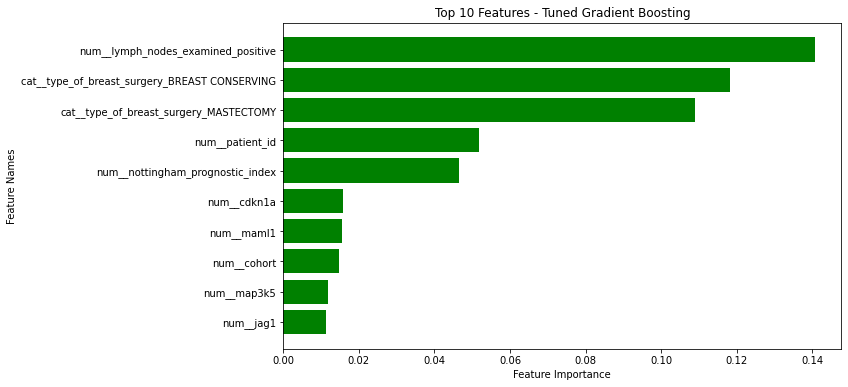

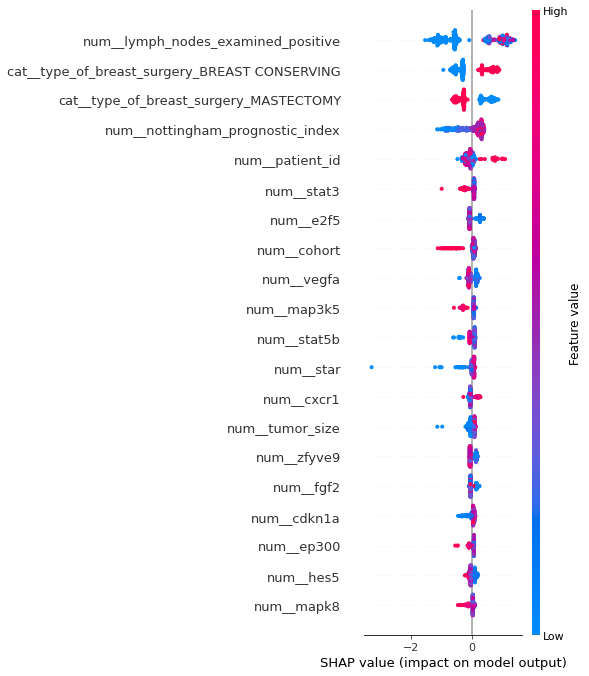

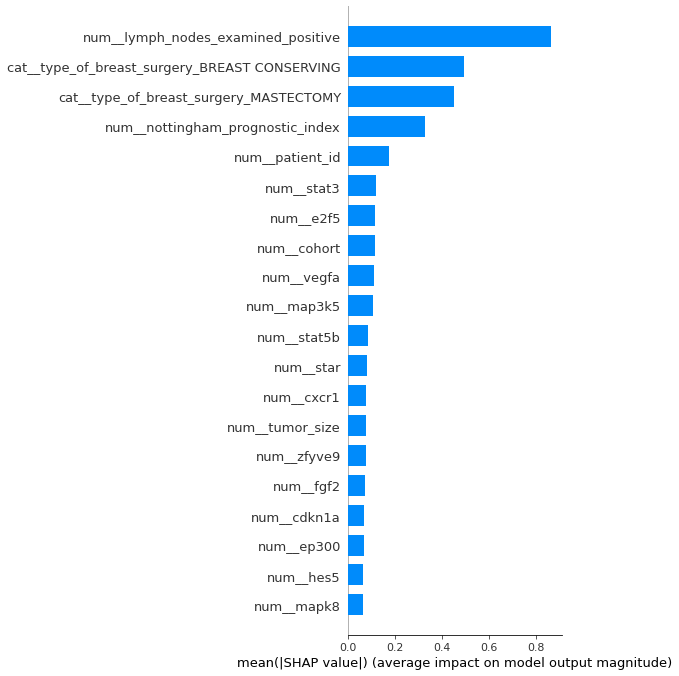

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Existing preprocessing steps remain unchanged
# ...

# Fine-Tuning Gradient Boosting
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

gb_tuned = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
gb_tuned.fit(X_train, y_train)

# Best Gradient Boosting Model
best_gb = gb_tuned.best_estimator_
y_pred_gb = best_gb.predict(X_test)

# Evaluate Tuned Gradient Boosting
accuracy_gb = accuracy_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
classification_rep_gb = classification_report(y_test, y_pred_gb, zero_division=1)

print("\nTuned Gradient Boosting Accuracy:", accuracy_gb)
print("\nClassification Report:\n", classification_rep_gb)
print("\nConfusion Matrix:\n", conf_matrix_gb)

# Feature Importance: Gradient Boosting
feature_importance_gb = best_gb.feature_importances_
important_features_gb = sorted(
    zip(selected_feature_names, feature_importance_gb), key=lambda x: x[1], reverse=True
)

print("\nTop 10 Important Features (Gradient Boosting):")
for feature, importance in important_features_gb[:10]:
    print(f"{feature}: {importance:.4f}")

# Visualization: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix Heatmap (Gradient Boosting)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization: Feature Importance Bar Chart
top_features_gb = important_features_gb[:10]
features_gb, importances_gb = zip(*top_features_gb)

plt.figure(figsize=(10, 6))
plt.barh(features_gb, importances_gb, color='green')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 10 Features - Tuned Gradient Boosting")
plt.gca().invert_yaxis()
plt.show()

# SHAP Analysis
explainer_gb = shap.Explainer(best_gb, X_train)
shap_values_gb = explainer_gb(X_test, check_additivity=False)

shap.summary_plot(shap_values_gb, X_test, feature_names=selected_feature_names)
shap.summary_plot(shap_values_gb, X_test, feature_names=selected_feature_names, plot_type="bar")


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Tuned Random Forest Accuracy: 0.847769028871391

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.14      0.22        58
           1       0.86      0.98      0.92       323

    accuracy                           0.85       381
   macro avg       0.68      0.56      0.57       381
weighted avg       0.81      0.85      0.81       381


Confusion Matrix:
 [[  8  50]
 [  8 315]]

Top 10 Important Features (Random Forest):
num__lymph_nodes_examined_positive: 0.0875
cat__type_of_breast_surgery_MASTECTOMY: 0.0553
num__nottingham_prognostic_index: 0.0459
cat__type_of_breast_surgery_BREAST CONSERVING: 0.0359
num__patient_id: 0.0155
num__vegfa: 0.0112
num__fgf2: 0.0079
num__nras: 0.0078
num__cdkn2b: 0.0069
num__cohort: 0.0064


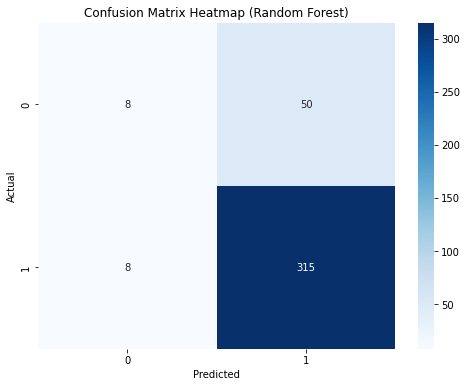

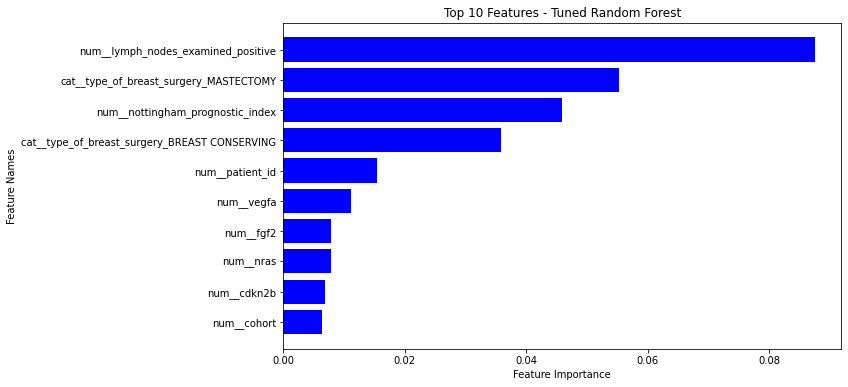

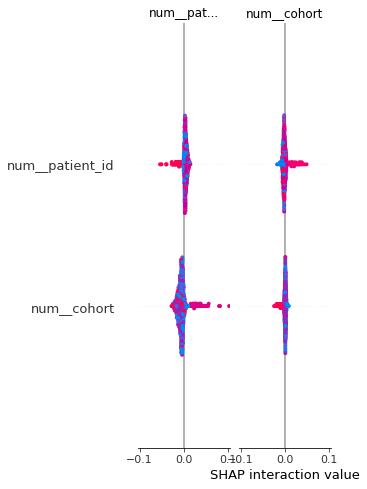

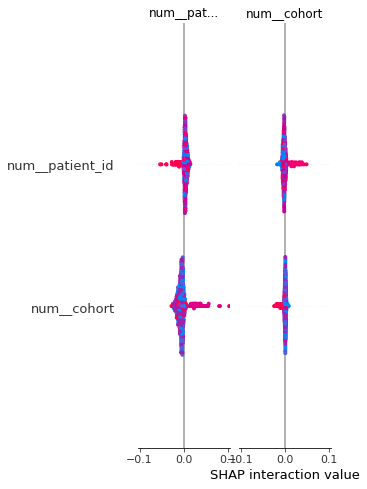

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Fine-Tuning Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf_tuned = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
rf_tuned.fit(X_train, y_train)

# Best Random Forest Model
best_rf = rf_tuned.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluate Tuned Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf, zero_division=1)

print("\nTuned Random Forest Accuracy:", accuracy_rf)
print("\nClassification Report:\n", classification_rep_rf)
print("\nConfusion Matrix:\n", conf_matrix_rf)

# Feature Importance: Random Forest
feature_importance_rf = best_rf.feature_importances_
important_features_rf = sorted(
    zip(selected_feature_names, feature_importance_rf), key=lambda x: x[1], reverse=True
)

print("\nTop 10 Important Features (Random Forest):")
for feature, importance in important_features_rf[:10]:
    print(f"{feature}: {importance:.4f}")

# Visualization: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix Heatmap (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization: Feature Importance Bar Chart
top_features_rf = important_features_rf[:10]
features_rf, importances_rf = zip(*top_features_rf)

plt.figure(figsize=(10, 6))
plt.barh(features_rf, importances_rf, color='blue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 10 Features - Tuned Random Forest")
plt.gca().invert_yaxis()
plt.show()

# SHAP Analysis
explainer_rf = shap.Explainer(best_rf, X_train)
shap_values_rf = explainer_rf(X_test, check_additivity=False)

shap.summary_plot(shap_values_rf, X_test, feature_names=selected_feature_names)
shap.summary_plot(shap_values_rf, X_test, feature_names=selected_feature_names, plot_type="bar")
